In [1]:
import matplotlib.pyplot as plt
from math import exp, cos, sin, pi
from numpy import dot
import numpy as np
from tqdm import tqdm

In [12]:
import numpy as np

class GridWorld:
    def __init__(self):
        # State space (excluding (2,2) and (3,2))
        self.states = [(i, j) for i in range(5) for j in range(5) if not ((i == 2 and j == 2) or (i == 3 and j == 2))]
        
        # Actions: up, down, left, right, stay
        self.actions = {'u': (-1, 0), 'd': (1, 0), 'l': (0, -1), 'r': (0, 1), 's': (0, 0)}
        
        # Initial state
        self.state = (0, 0)
        
        # Decay parameter
        self.gamma = 0.9
        
        # Reward
        self.reward = 0
        
    def get_new_state(self, action):
        old_state = self.state
        
        # Sample action according to probabilities
        if action in ['u', 'd']:
            action = np.random.choice([action, 'l', 'r', 's'], 1, [0.8, 0.05, 0.05, 0.1])[0]
        elif action in ['l', 'r']:
            action = np.random.choice([action, 'u', 'd', 's'], 1, [0.8, 0.05, 0.05, 0.1])[0]
        
        action = self.actions[action]
        candidate_state = tuple(map(sum, zip(self.state, action)))
        
        if candidate_state not in self.states:
            self.reward = 0
            return
        
        self.state = candidate_state
        
        if self.state == (4, 2):
            self.reward = -10
        elif self.state == (4, 4):
            self.reward = 10
        else:
            self.reward = 0
        
        return
    
states = [(i, j) for i in range(5) for j in range(5)]
state_to_index = dict([(tup, 5 * tup[0] + tup[1]) for tup in states])
index_to_state = dict([(state_to_index[i], i) for i in state_to_index])
lookup = dict([(i, state_to_index[i]) for i in state_to_index] + [(j, index_to_state[j]) for j in index_to_state])

def softmax(x):
    """Compute softmax values for each set of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

action_lookup = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}

def evaluate_policy(theta, total_episodes):
    policy = np.reshape(theta, (25, 4))
    G_list = []
    
    for _ in range(total_episodes):
        agent = GridWorld()
        state = agent.state
        moves = 0
        terminal = False
        G = 0
        
        while not terminal:
            state_idx = lookup[state]
            probs = softmax(policy[state_idx])
            action = np.argmax(probs)
            action = action_lookup[action]
            
            agent.get_new_state(action)
            G = agent.reward + agent.gamma * G
            state = agent.state
            moves += 1
            
            if state == (4, 4):
                terminal = True
                
            if moves > 10000:
                break
            
        G_list.append(G)
    
    return np.mean(G_list), np.std(G_list)




In [13]:
N = 50
SIGMA = 1

theta = np.random.normal(0, SIGMA, 25 * 4)
policy = np.reshape(theta, (25, 4))
G_list = []

for i in range(300):
    G = evaluate_policy(theta, N)
    cand_theta = np.random.normal(theta, SIGMA)
    cand_G = evaluate_policy(cand_theta, N)
    
    print(f'{i+1} cand: {cand_G[0]} best: {G[0]}', end='\r')
    
    if cand_G[0] > G[0]:
        theta = cand_theta.copy()
        G = cand_G
    
    G_list.append(cand_G)

trial = [j + 1 for j in range(len(G_list))]
mean = [tup[0] for tup in G_list]
std = [tup[1] for tup in G_list]


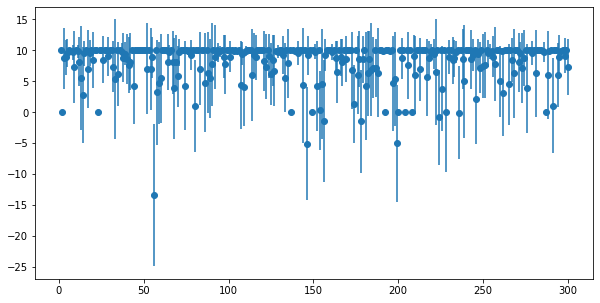

In [14]:
fig = plt.figure(figsize=(10, 5))
plt.errorbar(x=trial, y=mean, yerr=std, fmt='o')
plt.show()

In [5]:
policy = np.reshape(theta, (25, 4))
policy_actions = [action_lookup[np.argmax(softmax(policy[i]))] for i in range(25)]

table = np.array(['a' for _ in range(25)])
table = np.reshape(table, (5, 5))

for i in range(25):
    tup = lookup[i]
    table[tup] = policy_actions[i]

table[2, 2], table[3, 2], table[4, 4] = '_', '_', '_'
policy = np.reshape(theta, (25, 4))
table


array([['l', 'r', 'd', 'd', 'l'],
       ['l', 'l', 'd', 'u', 'd'],
       ['l', 'r', '_', 'l', 'd'],
       ['d', 'u', '_', 'd', 'l'],
       ['l', 'u', 'd', 'r', '_']], dtype='<U1')

In [6]:
state_set = [(i,j) for i in range(5) for j in range(5) if not ((i==2 and j==2) or (i==3 and j==2))]

action_map = {'up': (-1,0), 'down': (1,0), 'left': (0,-1), 'right': (0,1), 'stay': (0,0)}

gamma = 0.9

values = np.random.normal(0, 1, (5,5))
action = np.zeros((5,5))

def reward(state):
    if state == (4,2):
        return -10
    elif state == (4,4):
        return 10
    else:
        return 0
    
def is_legal(state, action):
    candState = tuple(map(sum, zip(state, action)))
    return candState in state_set

def summation(state, action):
    output = 0
    
    if state == (4,4):
        return output
    
    if action in ['up', 'down']:
        weight = {action: 0.8, 'left': 0.05, 'right': 0.05, 'stay': 0.1}
    elif action in ['left', 'right']:
        weight = {action: 0.8, 'up': 0.05, 'down': 0.05, 'stay': 0.1}
        
    for a in weight:
        a_tup = action_map[a]
        candState = tuple(map(sum, zip(state, a_tup)))
        if candState in state_set:
            output += weight[a] * (reward(candState) + gamma * values[candState])
            
    return output

for _ in range(1000):
    for state in state_set:
        all_actions = [summation(state, a) for a in ['up', 'down', 'left', 'right']]
        action[state] = np.argmax(all_actions)
        values[state] = max(all_actions)

action2 = [['_' for _ in range(5)] for _ in range(5)]
actions = ['u', 'd', 'l', 'r']

for state in state_set:
    i, j = state[0], state[1]
    action2[i][j] = actions[int(action[i,j])]
    
action2[4][4] = '_'
action2


[['r', 'd', 'r', 'd', 'd'],
 ['r', 'r', 'r', 'd', 'd'],
 ['r', 'u', '_', 'd', 'd'],
 ['u', 'u', '_', 'r', 'd'],
 ['u', 'u', 'r', 'r', '_']]

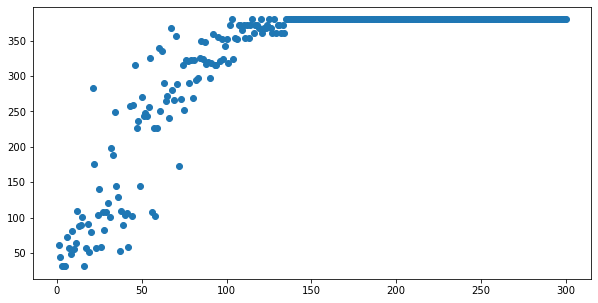

In [7]:
g = 9.8
mp = 0.1
mc = 10.0
l = 1.0

def sigmoid(par, vec):
    return 1 / (1 + exp(-1 * np.dot(par, vec)))

def validate(val, type):
    if type == 'x_dot':
        if val <= -10:
            return -10
        elif val >= 10:
            return 10
        else:
            return val
    elif type == 'theta_dot':
        if val <= -1 * pi:
            return -1 * pi
        elif val >= pi:
            return pi
        else:
            return val

class CartPole:
    def __init__(self):
        self.x = 0
        self.x_dot = 0
        self.theta = 0
        self.theta_dot = 0
        self.t = 0
        
    def get_current_state(self):
        return np.array([self.x, self.x_dot, self.theta, self.theta_dot, self.t])
    
    def get_new_state(self, F):
        x, x_dot, theta, theta_dot, t = self.x, self.x_dot, self.theta, self.theta_dot, self.t
        
        expr1 = (-1 * F - mp * l * (theta_dot ** 2) * sin(theta))
        theta_doubledot = (g * sin(theta) + cos(theta) * expr1) / (l * (4 / 3 - mp * (cos(theta) ** 2) / (mc + mp)))
        
        x_doubledot = (F + mp * l * ((theta_dot ** 2) * sin(theta) - theta_doubledot * cos(theta))) / (mc + mp)
        
        self.theta_dot = validate(theta_dot + 0.02 * theta_doubledot, 'theta_dot')
        self.x_dot = validate(x_dot + 0.02 * x_doubledot, 'x_dot')
        
        self.theta = self.theta + 0.02 * self.theta_dot
        self.x = x + 0.02 * self.x_dot
        self.t = t + 0.02
        
        return
    
    def get_action(self, par):
        prob_right = sigmoid(par, self.get_current_state())
        
        if prob_right > 0.5:
            return 10
        else:
            return -10

    def is_legal(self):
        if self.x <= -3 or self.x >= 3:
            return False
        elif self.theta <= -5 * pi / 12 or self.theta >= 5 * pi / 12:
            return False
        elif self.t >= 20:
            return False
        return True

def evaluate_policy(par, tot_eps):
    cart = CartPole()
    reward = 0
    while cart.is_legal():
        f = cart.get_action(par=par)
        cart.get_new_state(f)
        reward += 1
    return (reward, 0)

N = 50
SIGMA = 1

param = np.random.normal(0, SIGMA, 5)
G_list = []
G = evaluate_policy(param, N)

for i in range(300):
    SIGMA *= 1 / (1 + 0.001 * i)
    cand_param = np.random.normal(param, SIGMA)
    cand_G = evaluate_policy(cand_param, N)
    if cand_G[0] > G[0]:
        param = cand_param.copy()
        G = cand_G
    print(f'{i+1}) cand: {cand_G[0]} best: {G[0]}', end='\r')
    G_list.append(cand_G)

trial = [j + 1 for j in range(len(G_list))]
mean = [tup[0] for tup in G_list]
std = [tup[1] for tup in G_list]

fig = plt.figure(figsize=(10, 5))
plt.errorbar(x=trial, y=mean, yerr=std, fmt='o')
plt.show()


In [8]:
cart = CartPole()
reward = 0
while cart.is_legal():
    f = cart.get_action(par=param)
    cart.get_new_state(f)
    reward += 1
    
print(reward)


380


In [9]:
g = 9.8
mp = 0.1
mc = 10.0
l = 1.0

def sigmoid(par, vec):
    return 1 / (1 + exp(-1 * np.dot(par, vec)))

def validate(val, type):
    if type == 'x_dot':
        if val <= -10:
            return -10
        elif val >= 10:
            return 10
        else:
            return val
    elif type == 'theta_dot':
        if val <= -1 * pi:
            return -1 * pi
        elif val >= pi:
            return pi
        else:
            return val

class CartPole:
    def __init__(self):
        self.x = 0
        self.x_dot = 0
        self.theta = 0
        self.theta_dot = 0
        self.t = 0
        
    def get_current_state(self):
        return np.array([self.x, self.x_dot, self.theta, self.theta_dot, self.t])
    
    def get_new_state(self, F):
        x, x_dot, theta, theta_dot, t = self.x, self.x_dot, self.theta, self.theta_dot, self.t
        
        expr1 = (-1 * F - mp * l * (theta_dot ** 2) * sin(theta))
        theta_doubledot = (g * sin(theta) + cos(theta) * expr1) / (l * (4 / 3 - mp * (cos(theta) ** 2) / (mc + mp)))
        
        x_doubledot = (F + mp * l * ((theta_dot ** 2) * sin(theta) - theta_doubledot * cos(theta))) / (mc + mp)
        
        self.theta_dot = validate(theta_dot + 0.02 * theta_doubledot, 'theta_dot')
        self.x_dot = validate(x_dot + 0.02 * x_doubledot, 'x_dot')
        
        self.theta = self.theta + 0.02 * self.theta_dot
        self.x = x + 0.02 * self.x_dot
        self.t = t + 0.02
        
        return
    
    def get_action(self, par):
        prob_right = sigmoid(par, self.get_current_state())
        
        if prob_right > 0.5:
            return 10
        else:
            return -10

    def is_legal(self):
        if self.x <= -3 or self.x >= 3:
            return False
        elif self.theta <= -5 * pi / 12 or self.theta >= 5 * pi / 12:
            return False
        elif self.t >= 20:
            return False
        return True

cart = CartPole()
cart.get_new_state(10.0)


cart.is_legal()


True

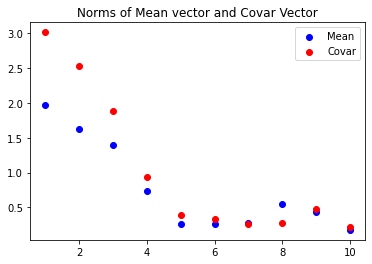

In [10]:
def evaluate_policy(par):
    cart = CartPole()
    reward = 0
    while cart.is_legal():
        f = cart.get_action(par=par)
        cart.get_new_state(f)
        reward += 1
    return reward

# Upto now using code from part (i)

eps = 0.2
K = 100
K_eps = 20

param_mean = np.random.normal(0, 1, (5))
covar = 2 * np.eye(5)
mean_list = [param_mean]
covar_list = [covar]
gain_list = []

for i in range(10):
    # Sample 100 policies from Normal(theta0, covar = 2*Identity)
    param_k = [np.random.multivariate_normal(param_mean, covar) for _ in range(K)]
    
    # Evaluate all 100 of them
    gain_list = [evaluate_policy(tk) for tk in param_k]
    
    # Get top 20 performing policies
    top_indices = np.argsort(gain_list)[-1:-21:-1]
    top_param = [param_k[i] for i in top_indices]
    
    # The new mean is the mean of these top policies
    param_mean = np.mean(top_param, axis=0)
    
    # Update covar like shown in question
    term = np.zeros_like(covar)
    for k in range(K_eps):
        dev = top_param[k] - param_mean
        term += np.outer(dev, dev)
        
    covar = (eps * covar + term) / (eps + K_eps)
    
    # Collect updates to check convergence
    mean_list.append(param_mean)
    covar_list.append(covar)
    gain_list.append(np.max(gain_list))

mean_norm_list = [np.linalg.norm(mean_list[i] - mean_list[i + 1]) for i in range(len(mean_list) - 1)]
covar_norm_list = [np.linalg.norm(covar_list[i] - covar_list[i + 1]) for i in range(len(covar_list) - 1)]

plt.title('Norms of Mean vector and Covar Vector')
plt.scatter([j + 1 for j in range(len(mean_norm_list))], mean_norm_list, c='blue')
plt.scatter([j + 1 for j in range(len(covar_norm_list))], covar_norm_list, c='red')
plt.legend(['Mean', 'Covar'])
plt.show()


In [11]:
final_reward = evaluate_policy(param_mean)
print(final_reward)


1001
